# Reading and analysing csv documents with Pandan

In [6]:
import pandas as pd
import numpy as np

In [7]:
#Since the data in csv files are separated by commas, we perform the separation process for reading
df = pd.read_csv('train.csv',sep=',')

In [8]:
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: >

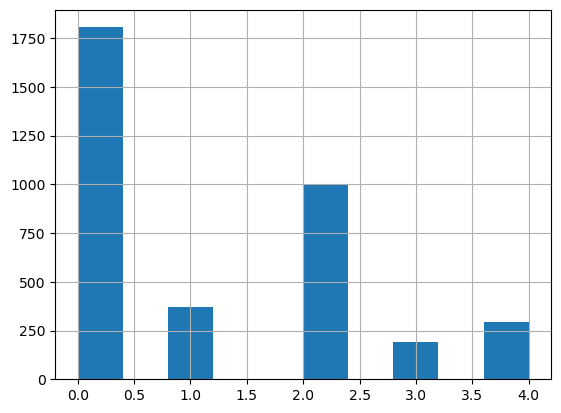

In [9]:
df['diagnosis'].hist()

# Reading Pictures

In [10]:
import os
files = os.listdir('train_img')

In [11]:
#we have a total of 3662 data
len(files)

3662

# Data Pre-processing

In [12]:
import cv2

In [14]:
img_list = []

#this library code shows which section we are in from the moment we run the code until the end and how long it will take to finish.
from tqdm import tqdm_notebook as tqdm

#We enter the loop to read all the data
for i in tqdm(files):
    image = cv2.imread('train_img\\'+i)
    #All images should be resised to be the same
    image = cv2.resize(image,(400,400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #we convert to grey format for threshold operation
    copy = image.copy()
    copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(copy,(5,5),0)
    thresh = cv2.threshold(blur,10,255, cv2.THRESH_BINARY)[1]
    #Contour finding-image cropping
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0][0]
    contour = contour[:,0,:]
    x1 = tuple(contour[contour[:,0].argmin()])[0]
    y1 = tuple(contour[contour[:,1].argmin()])[1]
    x2 = tuple(contour[contour[:,0].argmax()])[0]
    y2 = tuple(contour[contour[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    copy2 = image.copy()
    #Threshold for trimming
    if x2-x1 >100 and y2-y1> 100:
        copy2 = copy2[y1+y : y2-y , x1+x : x2-x]
        copy2 = cv2.resize(copy2,(400,400))
    #Pre-processing-CLAHE and Median Blur
    lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    last = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    med_last = cv2.medianBlur(last, 3)
    back_ground = cv2.medianBlur(last, 37)
    mask = cv2.addWeighted(med_last,1,back_ground,-1,255)
    last_img = cv2.bitwise_and(mask,med_last)
    img_list.append(last_img)

C:\Users\benru\AppData\Local\Temp\ipykernel_25580\3614721246.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(files):


  0%|          | 0/3662 [00:00<?, ?it/s]

In [12]:
import matplotlib.pyplot as plt

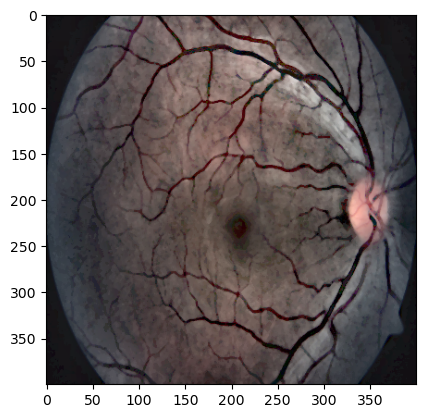

In [13]:
plt.imshow(img_list[6])

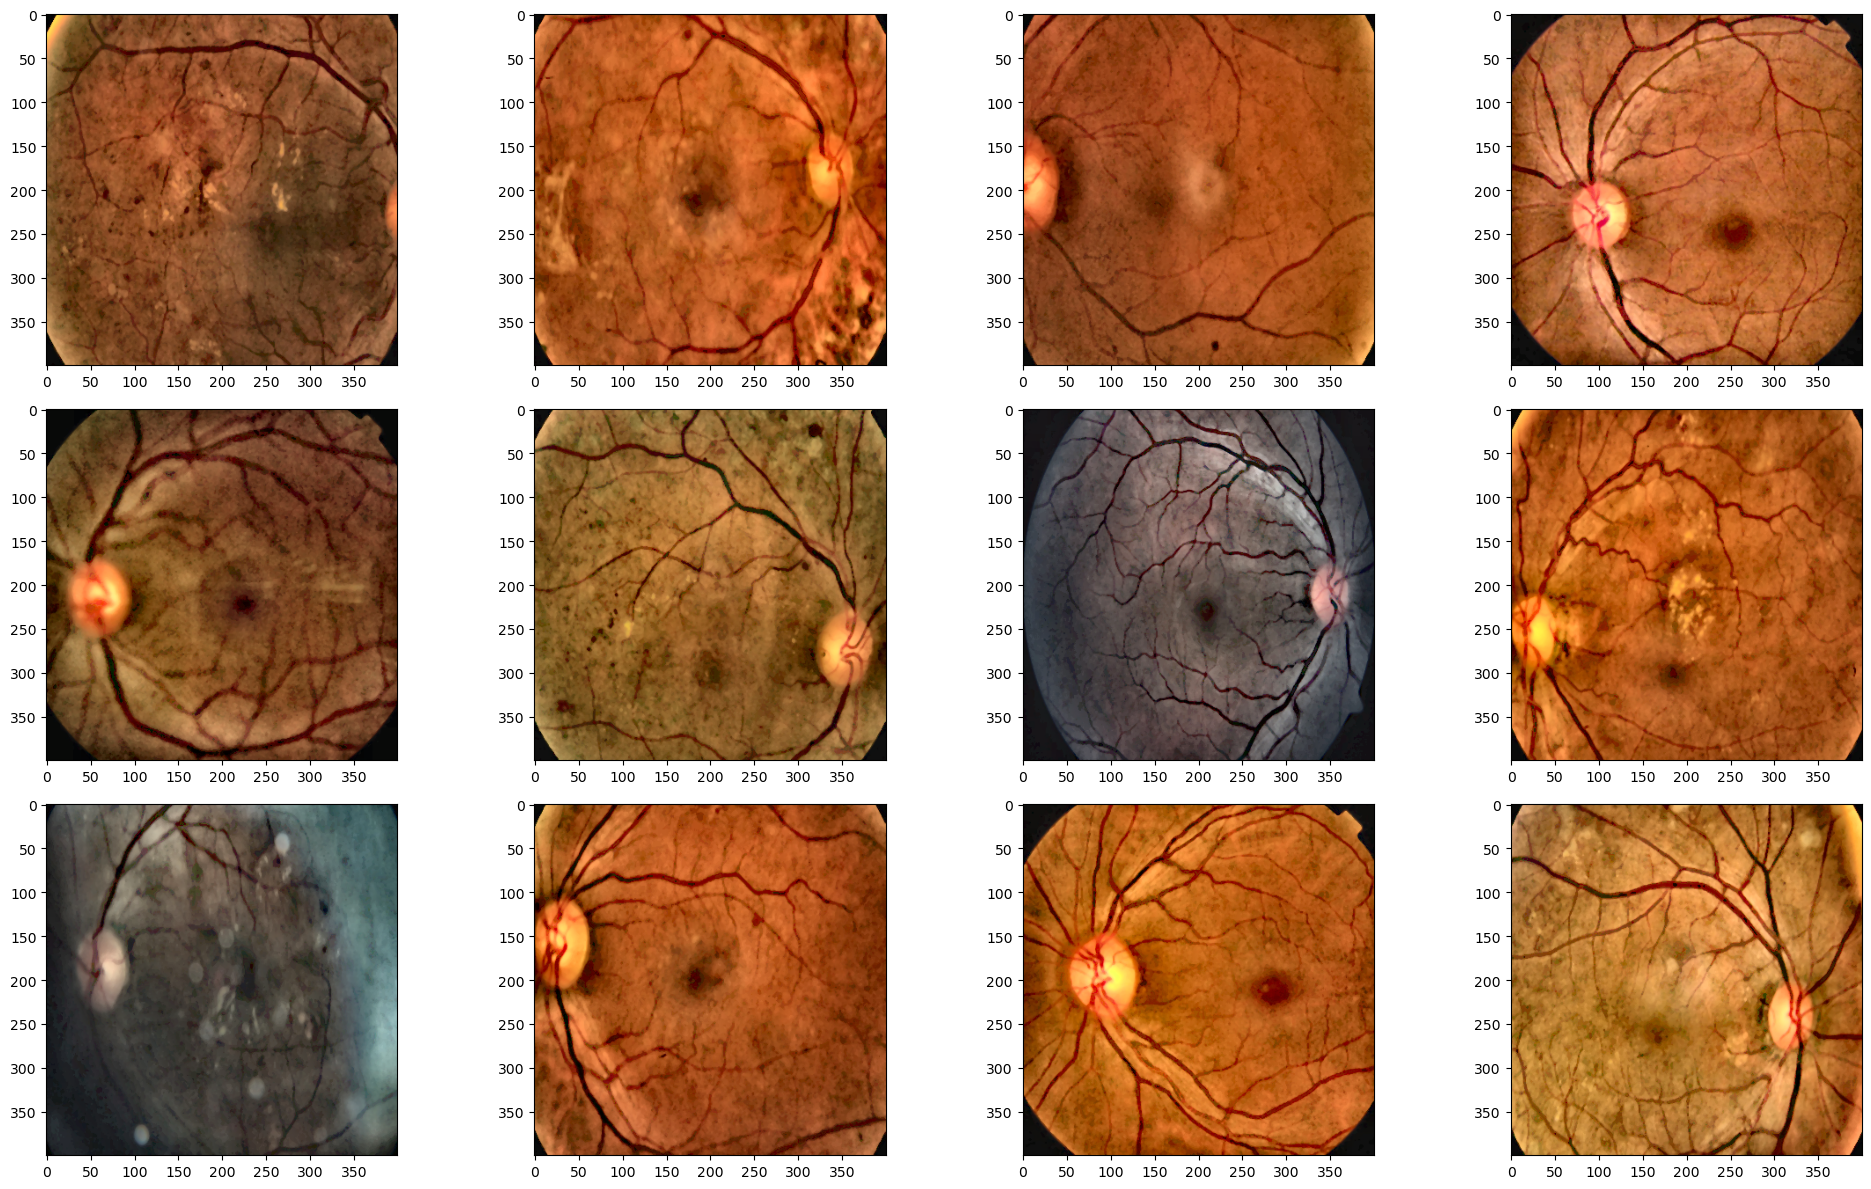

In [14]:
fig = plt.figure(figsize=(20,12))

for i in range(12):
    img = img_list[i]
    fig.add_subplot(3,4,i+1)
    plt.imshow(img)

plt.tight_layout()

In [15]:
#Converting the diagnostic data into the appropriate format while classifying the data to be entered into the training with One Code Encoding
y_train = pd.get_dummies(df['diagnosis']).values

In [16]:
df['diagnosis'][1]

4

In [17]:
y_train_son = np.ones(y_train.shape, dtype='uint8')

In [18]:
y_train_son[:,4] = y_train[:,4]

In [19]:
np.logical_or(0,0)

False

In [20]:
for i in range(3,-1,-1):
    y_train_son[:,i] = np.logical_or(y_train[:,i], y_train_son[:,i+1])

In [21]:
y_train_son

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [22]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [23]:
x_train = np.array(img_list)

In [24]:
x_train.shape

(3662, 400, 400, 3)

In [25]:
y_train_son.shape

(3662, 5)

In [26]:
#Separation for Training and Testing
from sklearn.model_selection import train_test_split

x_train, x_val , y_train, y_val = train_test_split(x_train,
                                                   y_train_son,
                                                   test_size=0.15,
                                                   random_state=2019,
                                                   shuffle=True)

In [27]:
x_train.shape, x_val.shape , y_train.shape, y_val.shape

((3112, 400, 400, 3), (550, 400, 400, 3), (3112, 5), (550, 5))

In [28]:
#We tensor the data
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
data_generator = datagen.flow(x_train,y_train,batch_size=2,seed=2020)

In [29]:
from efficientnet.keras import EfficientNetB5

In [30]:
#Using Transfer Learning
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(400,400,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5,activation = 'sigmoid'))

In [32]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.00005),metrics=['accuracy'])

In [33]:
#Decision making for learning rate
from keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(monitor = 'val_loss',
                      patience = 3,
                      verbose = 1,
                      mode='auto',
                      factor=0.25,
                      min_lr=0.000001)

In [35]:
#Model training
history = model.fit(data_generator,
                             steps_per_epoch = 1000,
                             epochs = 1,
                             validation_data = (x_val,y_val),
                             callbacks = [lr])

1000/1000 [==============================] - 2726s 3s/step - loss: 0.2091 - accuracy: 0.9545 - val_loss: 0.1475 - val_accuracy: 0.9473 - lr: 5.0000e-05
